In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('white')

In [4]:
df = pd.read_csv('movies.csv')
df.head()

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,Gross
0,Blood Red Sky,(2021),"\nAction, Horror, Thriller",6.1,\nA woman with a mysterious illness is forced ...,\n Director:\nPeter Thorwarth\n| \n Star...,"21,062",121.0,NaN
1,Masters of the Universe: Revelation,(2021– ),"\nAnimation, Action, Adventure",5.0,\nThe war for Eternia begins again in what may...,"\n \n Stars:\nChris Wood, \nSara...","17,870",25.0,NaN
2,The Walking Dead,(2010–2022),"\nDrama, Horror, Thriller",8.2,\nSheriff Deputy Rick Grimes wakes up from a c...,"\n \n Stars:\nAndrew Lincoln, \n...","885,805",44.0,NaN
3,Rick and Morty,(2013– ),"\nAnimation, Adventure, Comedy",9.2,\nAn animated series that follows the exploits...,"\n \n Stars:\nJustin Roiland, \n...","414,849",23.0,NaN
4,Army of Thieves,(2021),"\nAction, Crime, Horror",NaN,"\nA prequel, set before the events of Army of ...",\n Director:\nMatthias Schweighöfer\n| \n ...,NaN,NaN,NaN


In [5]:
df.shape

(9999, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MOVIES    9999 non-null   object 
 1   YEAR      9355 non-null   object 
 2   GENRE     9919 non-null   object 
 3   RATING    8179 non-null   float64
 4   ONE-LINE  9999 non-null   object 
 5   STARS     9999 non-null   object 
 6   VOTES     8179 non-null   object 
 7   RunTime   7041 non-null   float64
 8   Gross     460 non-null    object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [7]:
df['RATING'] = df['RATING'].astype(pd.Float32Dtype())
df['RunTime'] = df['RunTime'].astype(pd.Float32Dtype())
for col in df.columns[df.dtypes == 'object']:
    df[col] = df[col].astype(pd.StringDtype())
df['VOTES'] = df['VOTES'].str.replace(',', '').astype(pd.Int32Dtype())

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MOVIES    9999 non-null   string 
 1   YEAR      9355 non-null   string 
 2   GENRE     9919 non-null   string 
 3   RATING    8179 non-null   Float32
 4   ONE-LINE  9999 non-null   string 
 5   STARS     9999 non-null   string 
 6   VOTES     8179 non-null   Int32  
 7   RunTime   7041 non-null   Float32
 8   Gross     460 non-null    string 
dtypes: Float32(2), Int32(1), string(6)
memory usage: 615.3 KB


  column_name  notna_values  na_values
0      MOVIES          9999          0
1        YEAR          9355        644
2       GENRE          9919         80
3      RATING          8179       1820
4    ONE-LINE          9999          0
5       STARS          9999          0
6       VOTES          8179       1820
7     RunTime          7041       2958
8       Gross           460       9539


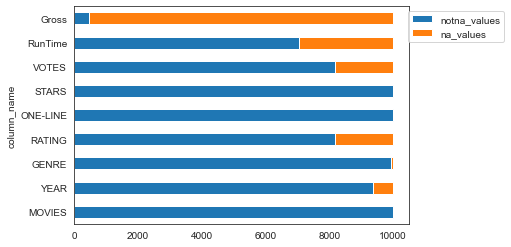

In [9]:
def show_null_analysis(df: pd.DataFrame):
    values_info_df = pd.DataFrame([{ 
            'column_name': col,
            'notna_values': df[col].notna().sum(),
            'na_values': df[col].isna().sum(),
    } for col in df.columns ])
    print(values_info_df)
    values_info_df.set_index('column_name').plot(kind='barh', stacked=True)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.draw()

show_null_analysis(df)

  column_name  notna_values  na_values
0      MOVIES          9959          0
1        YEAR          9355        604
2       GENRE          9919         40
3      RATING          8179       1780
4    ONE-LINE          9959          0
5       STARS          9959          0
6       VOTES          8179       1780
7     RunTime          7041       2918
8       Gross           460       9499


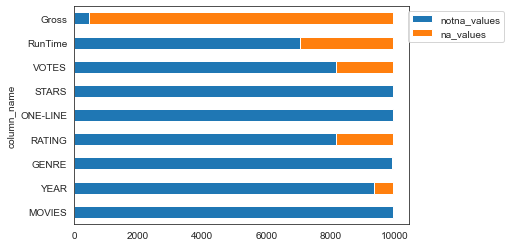

In [10]:
df = df.dropna(thresh=df.shape[1] - 5)  # allow 5 nulls
show_null_analysis(df)

In [11]:
rows = df[df['ONE-LINE'].str.contains("add a plot", case=False)].index
columns = ['ONE-LINE']
df.loc[rows, columns] = pd.NA

In [12]:
duplication_scope = ['MOVIES', 'YEAR']
duplicated = df.duplicated(subset=duplication_scope, keep=False)
duplicated.sum()

3471

In [13]:
def get_index_of_record_with_least_na(df):
    return df.isna().sum(axis=1).idxmin()
index_of_record_with_least_na = df[duplicated].groupby(['MOVIES', 'YEAR']).apply(get_index_of_record_with_least_na)

df = df.loc[pd.Index(index_of_record_with_least_na.values).union(df[~duplicated].index)]

  column_name  notna_values  na_values
0      MOVIES          6820          0
1        YEAR          6404        416
2       GENRE          6782         38
3      RATING          5856        964
4    ONE-LINE          6460        360
5       STARS          6820          0
6       VOTES          5856        964
7     RunTime          5349       1471
8       Gross           460       6360


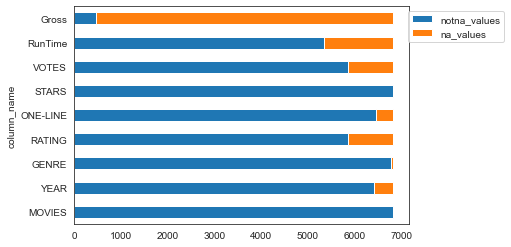

In [14]:
show_null_analysis(df)

---

3 things

- genre
- rating
- gross

## Model Building

### Predicting Genre

#### Raw Features

Features useful for predicting generes

In [15]:
features = ['MOVIES', 'ONE-LINE', 'STARS']
target = ['GENRE']

In [16]:
df[features + target]

,MOVIES,ONE-LINE,STARS,GENRE
0,Blood Red Sky,A woman with a mysterious illness is forced i...,Director: Peter Thorwarth | Stars: P...,"Action, Horror, Thriller"
1,Masters of the Universe: Revelation,The war for Eternia begins again in what may ...,"Stars: Chris Wood, Sarah Mi...","Animation, Action, Adventure"
2,The Walking Dead,Sheriff Deputy Rick Grimes wakes up from a co...,"Stars: Andrew Lincoln, Norm...","Drama, Horror, Thriller"
3,Rick and Morty,An animated series that follows the exploits ...,"Stars: Justin Roiland, Chri...","Animation, Adventure, Comedy"
4,Army of Thieves,"A prequel, set before the events of Army of t...",Director: Matthias Schweighöfer | St...,"Action, Crime, Horror"
...,...,...,...,...
9956,Sexify,Natalia decides to build an app that optimize...,Director: Piotr Domalewski | Stars: ...,"Comedy, Drama"
9964,AlRawabi School for Girls,<NA>,Director: Tima Shomali | Stars: Sals...,Drama
9993,Totenfrau,<NA>,Director: Nicolai Rohde | Stars: Fel...,"Drama, Thriller"
9995,Arcane,<NA>,,"Animation, Action, Adventure"


  column_name  notna_values  na_values
0      MOVIES          6820          0
1    ONE-LINE          6460        360
2       STARS          6820          0
3       GENRE          6782         38


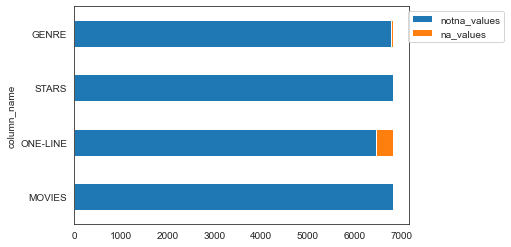

In [17]:
show_null_analysis(df[features+target])

Remove Nulls

  column_name  notna_values  na_values
0      MOVIES          6782          0
1    ONE-LINE          6444        338
2       STARS          6782          0
3       GENRE          6782          0


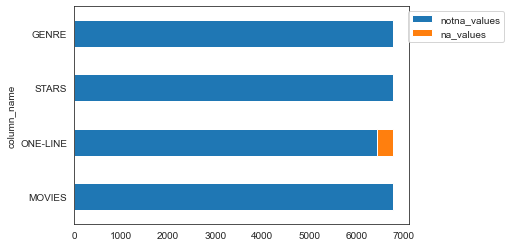

In [18]:
df1 = df[features+target][df['GENRE'].notna()]
show_null_analysis(df1)

#### Processed Features

Director

In [19]:
import re
directors = df1['STARS'].str.extract(r'(?:Director:\s?(?:\n+)?\s?(.+))', flags=re.IGNORECASE)[0]
directors_oh = pd.get_dummies(directors)
directors_oh.head()

,Aadish Keluskar,Aaron Augenblick,Aaron Burns,Aaron Lieber,Aaron Sorkin,Abdelhamid Bouchnak,Abhay Kumar,Abhijit Panse,Abhinay Deo,Adam Berg,...,Zoltan Paul,Zsolt Pálfi,Zulkarnain Azhar,Álex de la Iglesia,Álvaro Brechner,Álvaro Fernández Armero,Ángel Gómez Hernández,Ángeles Reiné,Åke Sandgren,Ömer Ugur
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Stars

In [20]:
import re
stars = df1['STARS'].str.extract(r'\|?\s?Stars:\s?(?:\n)?\s?([\w\W]+)', flags=re.IGNORECASE)[0]
stars_oh = stars.replace(r'(?:\n)|\s+', '', regex=True).str.get_dummies(',')
stars_oh.head()

,2'LiveBre,2Chainz,2Mex,50Cent,A.J.Baime,A.J.Daulerio,A.J.LoCascio,A.N.T.I.,ABoogiewitdaHoodie,AJBowen,...,ÖzgeBorak,ÖzgeÖzpirinçci,ÖzgürEmreYildirim,ÖzgürOzan,ÖzkanUgur,ÖzzNûjen,ÚrsulaCorberó,ÚrsulaPruneda,ÜlküDuru,ÞorsteinnBachmann
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
stars_oh.shape

(6782, 16197)

One Line

In [22]:
description = (df1['MOVIES'] + df1['ONE-LINE'].fillna(''))

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words='english')
bag_of_words = count.fit_transform(description)

In [24]:
words_oh = pd.DataFrame(bag_of_words.toarray(), index=description.index)
words_oh.columns = words_oh.columns.astype(pd.StringDtype())

In [25]:
X = pd.concat([
    directors_oh,
    stars_oh,
    words_oh
], axis=1)

In [27]:
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

X = StandardScaler().fit_transform(X)
X_csr = csr_matrix(X)

In [32]:
tsvd = TruncatedSVD(n_components=10)

In [33]:
tsvd.fit(X_csr)

TruncatedSVD(n_components=10)

In [35]:
tsvd.explained_variance_ratio_

array([0.00048969, 0.00040887, 0.00035556, 0.00035398, 0.00034488,
       0.00033627, 0.0003303 , 0.00032779, 0.00032614, 0.00032203])

#### Target

In [27]:
y = df1['GENRE'].str.strip().str.get_dummies(sep=',')
y.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Model

In [28]:
X.shape, y.shape

((6782, 40590), (6782, 54))

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)



model.fit(X_train, y_train)

ValueError: y should be a 1d array, got an array of shape (6103, 54) instead.

In [ ]:
model.score(X_test, y_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, model.predict(X_test)))